In [1]:
import qiskit as qk
from qiskit.circuit.classical import expr
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.options.sampler_options import SamplerOptions
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from pprint import pprint
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# See also https://docs.quantum.ibm.com/guides/primitives-examples 

In [4]:
service = QiskitRuntimeService(name="olcf")
#service = QiskitRuntimeService(channel="ibm_quantum")
options = SamplerOptions()
options.default_shots=1000

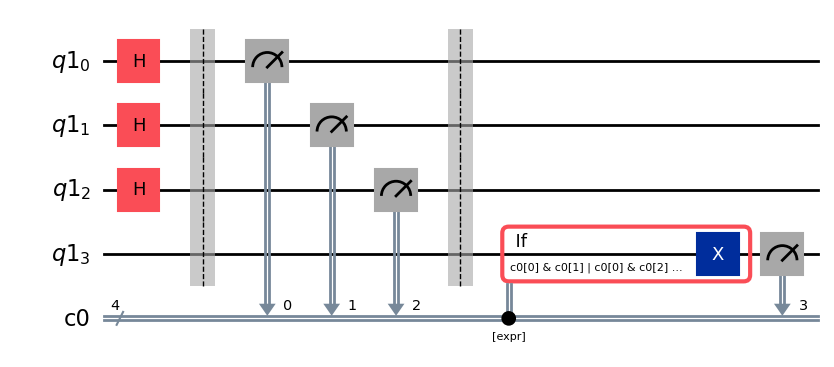

In [2]:
#...!...!....................
def feedF_circA(n=4):
    qr = qk.QuantumRegister(n)
    cr = qk.ClassicalRegister(n)
    qc = qk.QuantumCircuit(qr,cr)

    for i in range(0, n-1):
        qc.h(i)
    qc.barrier()
    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)
    qc.barrier()
    # Compute the majority using the defined expression
    # majority:  (b0 and b1) or (b0 and b2) or (b1 and b2)
    b01=expr.bit_and(cr[0],cr[1]) # classical bits
    b02=expr.bit_and(cr[0],cr[2]) # classical bits
    b12=expr.bit_and(cr[1],cr[2]) # classical bits
    bxx= expr.bit_or(b01, b02)
    majority= expr.bit_or(bxx,b12)
    with qc.if_test(majority): qc.x(3)

    qc.measure(3, 3)
    return qc
qc=feedF_circA(4)
qc.draw('mpl', idle_wires=False)

### A) Run on real HW



In [5]:
#backName='ibm_kyoto'
backName='ibm_kyiv'
backend = service.get_backend(backName)

Here we create a pass manager based on the backend and then we run the pass manager on the virtual circuit to create the physical circuit ready to run

In [6]:
# transpiler(..) is now generate_preset_pass_manager(..)
mypass = generate_preset_pass_manager(backend=backend,optimization_level=3, seed_transpiler=44)
qcT = mypass.run(qc)

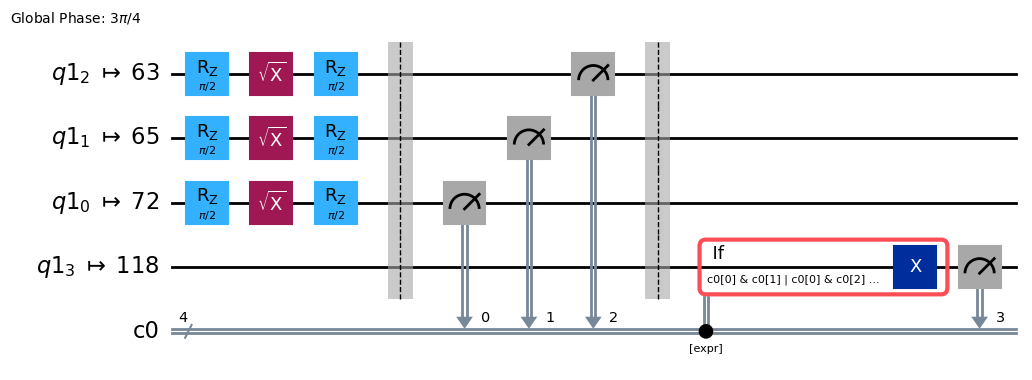

In [7]:
qcT.draw('mpl', idle_wires=False)

In [8]:
qcEL=(qcT,)  # quant circ executable list
sampler = Sampler(backend=backend, options=options)
job = sampler.run(qcEL)
result=job.result()

In [12]:
print('job:',job)
pprint(result[0].data)
pprint(result[0].data.c0.get_counts())

job: <RuntimeJobV2('ctcmr2rakxxg008kctgg', 'sampler')>
DataBin(c0=BitArray(<shape=(), num_shots=1000, num_bits=4>))
{'0000': 156,
 '0001': 128,
 '0010': 135,
 '0100': 133,
 '1011': 110,
 '1101': 118,
 '1110': 128,
 '1111': 92}


### B) Run on fake backend
#### Needs Aer 0.15.0  to work: https://github.com/Qiskit/qiskit-aer/milestone/28

In [14]:
#backName='ibm_kyoto'
noisy_backend = service.get_backend(backName)
backend2 = AerSimulator.from_backend(noisy_backend)

qcT = qk.transpile(qc, backend=backend2, optimization_level=3)
print('use noisy_backend =', noisy_backend.name )

use noisy_backend = ibm_kyiv


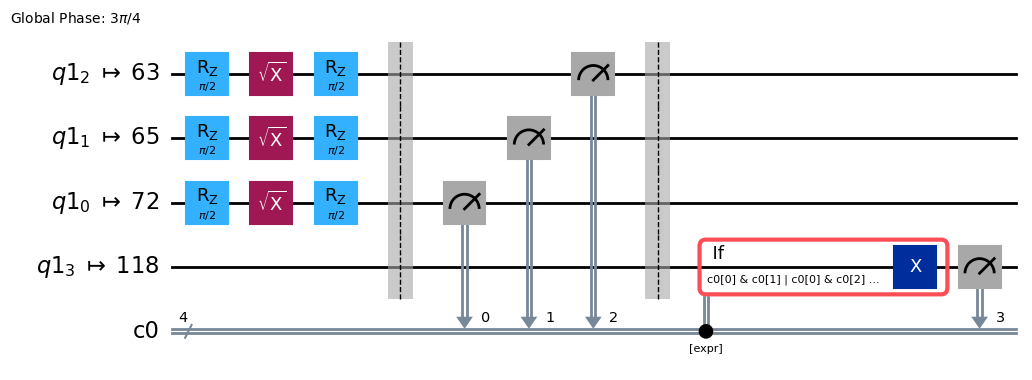

In [15]:
#print(qcT.draw(output='text',idle_wires=False)) 
qcT.draw('mpl', idle_wires=False)

In [26]:
print('job started,  nq=%d  at %s ...'%(qcT.num_qubits,backend.name))
sampler = Sampler(backend=backend2, options=options)
job = sampler.run([qcT])
result=job.result()
jobMD=result.metadata    

job started,  nq=127  at ibm_kyoto ...


CircuitError: "Bit 'Qubit(QuantumRegister(4, 'q25'), 3)' is not in the circuit."

In [27]:
pprint(result[0].data.meas.get_counts())

AttributeError: 'DataBin' object has no attribute 'meas'